# Rotman MMA Datathon: Instacart Analysis

### Introduction 
Over the years, the demand for grocery deliveries and pick-ups services in Canada have been gradually increasing with platforms such as Instacart becoming more popular among customers. However, unlike food delivery services, Instacart shoppers do not always have the most updated information regarding whether a particular grocery item is available at large chain supermarkets. In addition, Instacart shoppers also have to spend more time figuring out where requested items are located in various supermarkets which increases the waiting time for customers. 

In order to resolve both customers' and Instacart personal shoppers' pain point of figuring out whether an item is available or not, an 'Instabasket' aisle is introduced. This customized 'Instabasket' aisle is a one-stop destination with 1,000 products available for Instacart customers. With the Instabasket aisle, Instacart personal shoppers won't need to spend too much time searching for items in different aisles. If an item requested is not available, customers may have an option to substitute the requested item with another item in the Instabasket aisle. 


### Problem Statement 
As mentioned before, the Instabasket aisle will serve as a one-stop destination for Instacart personal shoppers. To ensure that the Instabasket aisle is as effective as it can be in satisfying Instacart customers' demands, the products selected in this aisle must have high demands and can be a good substitute for a large number of products. While the total limit for the number of products in this aisle is 1,000 products, there is 100 spaces for refridgerated items and 100 spaces for frozen items available within these 1000 slots. Thereby, the aim of this project is to identify a list of 1,000 products that can optimize the Instabasket aisle's goal of fulfilling as many orders as possible. 

In [1]:
# Import libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# Set the style for the visualizations in the notebook
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette('icefire')

In [3]:
# Load the dataset 
df = pd.read_csv('mma_mart.csv')

In [4]:
# View the head of the dataset 
df.head()

,order_id,product_id,product_name,aisle_id,aisle,department_id,department
0,1,49302,Bulgarian Yogurt,120,yogurt,16,dairy eggs
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,other creams cheeses,16,dairy eggs
2,1,10246,Organic Celery Hearts,83,fresh vegetables,4,produce
3,1,49683,Cucumber Kirby,83,fresh vegetables,4,produce
4,1,43633,Lightly Smoked Sardines in Olive Oil,95,canned meat seafood,15,canned goods


## Part 1: Product Analysis 

Firstly, I will explore the large range of products provided by the dataset. An initial count of unique Product ID shows that there is a total of 35,070 products in the dataset. These products have 2 levels of categorization. Firstly they are categorized from the top down into 21 departments where each department has aisles where the products are grouped into. There is a total of 154 aisles mentioned in the dataset. Apparently, the naming of the departments is similar to the department names that we often observe in supermarkets (i.e. Alcohol, Dairy, Produce, Beverages, etc.). This existing product categorization into departments is based on characteristics of the products regarding their shelf life, storage conditions, functionality and targeted users. 

Upon further inspections of each product names, I figured out that there are many products which have similar names. For instance, while 'Bag of Bananas', 'Bananas', and 'Banana' are labelled as different products, they are fundamentally the same item. Thus, I will study the names of the products in this part with the aim of grouping similar items together in order to narrow down the list of items to select from. 

In [5]:
# Create a dataset containing unique product IDs on each row with an aggregated count of the number of times the product was ordered
products_df = pd.DataFrame(df.groupby('product_id')[['product_name','department','aisle']].value_counts())

In [6]:
# View the head of the dataset 
products_df.head()

,,,,0
product_id,product_name,department,aisle,
1,Chocolate Sandwich Cookies,snacks,cookies cakes,60
2,All-Seasons Salt,pantry,spices seasonings,2
3,Robust Golden Unsweetened Oolong Tea,beverages,tea,4
4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,frozen,frozen meals,9
8,Cut Russet Potatoes Steam N' Mash,frozen,frozen produce,2


In [7]:
# Reset the index of the products dataframe 
products_df = products_df.reset_index()

In [8]:
# Rename column '0' to 'Number of Order'
products_df = products_df.rename(columns={0: 'num_order'})

In [9]:
# Check the first 5 rows of the dataframe again to view the changes
products_df.head()

,product_id,product_name,department,aisle,num_order
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,60
1,2,All-Seasons Salt,pantry,spices seasonings,2
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea,4
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals,9
4,8,Cut Russet Potatoes Steam N' Mash,frozen,frozen produce,2


In [10]:
# Use Scikit-Learn's vectorizer to transform the product names into a sparse matrix for occuring frequencies analysis
# Import Scikit-Learn's Count Vectorizer 
from sklearn.feature_extraction.text import CountVectorizer

#### Find keywords that are unique to each department 

In [11]:
# Create a dataframe storing list of unique product names for each department
dept_products = pd.DataFrame(products_df.groupby('department')['product_name'].unique())

In [12]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at least 5% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.05, ngram_range=(1,1), stop_words='english')

In [13]:
# Create a dictionary to store the outputs of the loop
dept_high_freq_terms = {}

# Looping through each row in the dataframe containing a list of product names in each aisle
for i, name in enumerate(dept_products.index.values):
    # Retrieve the product names
    product_names = dept_products.iloc[i].values[0] 
    # Fit the product names to the count vectorizer
    bagofwords.fit(product_names)
    # Retrieve a list of frequently occuring terms within the list of product names 
    freq_terms = bagofwords.get_feature_names_out()
    # Add the frequently occuring terms to a dictionary with the aisle name as a key and the list of as the key's values 
    dept_high_freq_terms[name] = freq_terms

#### Find keywords that are unique to each aisle

In [14]:
# Create a dataframe storing list of unique product names for each aisle 
aisle_products = pd.DataFrame(products_df.groupby('aisle')['product_name'].unique())

In [15]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at least 5% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.05, ngram_range=(1,1), stop_words='english')

In [16]:
# Create a dictionary to store the outputs of the loop
aisle_high_freq_terms = {}

# Looping through each row in the dataframe containing a list of product names in each aisle
for i, name in enumerate(aisle_products.index.values):
    # Retrieve the product names
    product_names = aisle_products.iloc[i].values[0] 
    # Fit the product names to the count vectorizer
    bagofwords.fit(product_names)
    # Retrieve a list of frequently occuring terms within the list of product names 
    freq_terms = bagofwords.get_feature_names_out()
    # Add the frequently occuring terms to a dictionary with the aisle name as a key and the list of as the key's values 
    aisle_high_freq_terms[name] = freq_terms

#### Use word stems to avoid double counting product names

In [17]:
# Import NLTK libraries 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Instantiate PorterStemmer 
ps = PorterStemmer()

In [18]:
# Create a dictionary with a list of stem words for each word in the product name 
all_stems = []
name_stems = {}
for product in list(products_df['product_name'].values):
    words = word_tokenize(product)
    stem_list = []
    for w in words:
        stem = ps.stem(w)
        all_stems.append(stem)
        stem_list.append(stem)
    name_stems[product] = stem_list

In [19]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at most 10% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.0001, ngram_range=(1,1), stop_words='english').fit(all_stems)

# Fit and transform the product names by using the vectorizer 
transform = bagofwords.transform(all_stems)

In [20]:
# Create a dataframe to store the count vectorizer outputs 
stems_cv = pd.DataFrame({'word_stem': bagofwords.get_feature_names_out(), 'frequency': transform.toarray().sum(axis=0)})

In [21]:
# Sort the frequency count in descending order 
stems_cv_plot = stems_cv.sort_values(by='frequency', ascending=False)[:20]

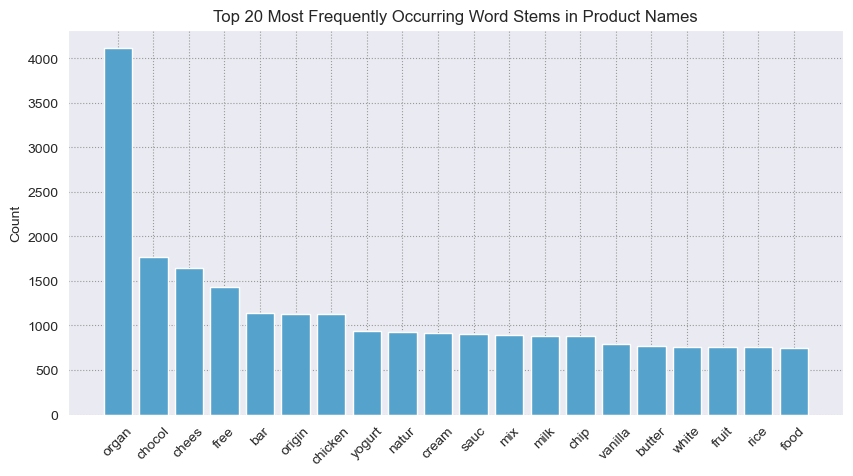

In [22]:
# Plot a bar chart to show the product names with the highest occurances 
plt.figure(figsize=(10,5))
plt.bar(stems_cv_plot['word_stem'], stems_cv_plot['frequency'])
plt.title(f"Top {stems_cv_plot.shape[0]} Most Frequently Occurring Word Stems in Product Names")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

After a count of all stem words coming from the products' names, labels on products such as 'organic' and 'gluten free' appear quite frequently. Especially, as the stem word with the highest count, the word 'organic' may be associated with products coming from more than one department. Thus, to account for the distinction in the characteristics of these products, they should be a category of their own. 

In the following sections, I will make an attempt to match each product names with one stem word that best represent what the product is. Due to the large amount of products in the dataset, it is more reasonable to do one hot encode rather than manually labelling each item despite how the second may be a more accurate method. A few assumptions will be made regarding the products' labels: 
1. The product's chosen stem word will be the stem word with the highest occuring frequency within the product's departments then aisle. As the aim of the stem word is to categorize items from different departments or aisle which may share some similarities regarding their content (i.e. frozen strawberries from the frozen department and organic strawberries from the produce department are both made out of strawberries), the stem word will be heavily determined by the word's popularity within the dataset to avoid choosing a specific stem word that refer to a highly specific item (i.e. tortilla). 


2. If the words in the product's name does not match with any frequently occuring stem words in the product's respective department or aisle, the words' popularity will be compared against the frequency of the word in the products dataset as a whole. In case the products have more than one word in its name then the word with the highest occurances in the dataset will be chosen. 

In [23]:
# Find the word stem for list of ignored words 
ignore_word = ['original', 'organic', 'gluten', 'free', 'food', 'foods', 'fruit', 'size', 'stage', 'super']
ignore_stems = [ps.stem(w) for w in ignore_word]

In [24]:
# Converting the list of keywords in each department into word stems 
dept_stems = {}
for department in list(dept_high_freq_terms.keys()):
    all_stems = []
    for terms in list(dept_high_freq_terms[department]):
        stem = ps.stem(terms)
        if stem not in ignore_stems:
            all_stems.append(stem)
    dept_stems[department] = all_stems

In [25]:
# Converting the list of keywords in each aisle into word stems 
aisle_stems = {}
for aisle in list(aisle_high_freq_terms.keys()):
    all_stems = []
    for terms in list(aisle_high_freq_terms[aisle]):
        stem = ps.stem(terms)
        if stem not in ignore_stems:
            all_stems.append(stem)
    aisle_stems[aisle] = all_stems

In [26]:
# Find the most relevant stem word associate with each product 
product_best_stem = {}

for i in range(products_df.shape[0]):
    product_name = products_df['product_name'].iloc[i]
    stem_list = name_stems[product_name]
    max_score = 0
    best_stem = ''    
    for item in stem_list:
        if item in dept_stems[products_df['department'].iloc[i]]:
            best_stem = item
        elif item in aisle_stems[products_df['aisle'].iloc[i]]:
            best_stem = item
        if item in list(stems_cv['word_stem'].values):
            if (best_stem == '') and (item not in ignore_stems):
                score = stems_cv[stems_cv['word_stem'] == item]['frequency'].values[0]
                if score > max_score:
                    max_score = score
                    best_stem = item
    
    product_best_stem[product_name] = best_stem

In [27]:
# Assign the category stem word to the products 
stems = []
for i in range(products_df.shape[0]):
    stems.append(product_best_stem[products_df['product_name'].iloc[i]])

products_df['stem_group'] = stems

In [28]:
# Count number of unique stem groups 
products_df['stem_group'].nunique()

1149

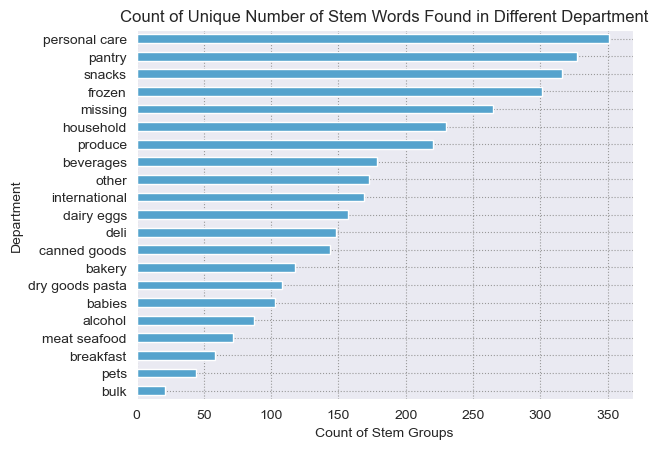

In [29]:
# Plot chart to show the count of stem group in each department 
products_df.groupby('department')['stem_group'].nunique().sort_values().plot(kind='barh')
plt.title('Count of Unique Number of Stem Words Found in Different Department')
plt.ylabel('Department')
plt.xlabel('Count of Stem Groups')
plt.show()

The chart above shows that the personal care, pantry, and snacks department have the highest count of stem words from product groups which indicate that these departments may carry a diverse selection of products that are very different from one another. In contrary, departments on the lower end of the chart suggest that these departments may carry a smaller variety of products. 

### Features Engineering

#### Food Products
Label items in the products dataset to identify the products that can be consumed by humans. Note that babies' food do not count towards food products because these items are not frequently purchased for frequent consumption by the consumers in the dataset. 

Assuming that the department name is a reliable product category, the department name will be used to determine whether an item is a food product or not. Since the items in the dataset belong to a supermarket, I anticipate that a majority of the products will be a food item. 

In [30]:
# Create a list of departments that do NOT hold food products
non_food_dept = ['household', 'babies', 'pets', 'personal care']

In [31]:
# Create an empty list to store the binary outputs
food = []
# Looping through each row to label food items based on their department 
for i in range(products_df.shape[0]):
    if products_df['department'].iloc[i] in non_food_dept:
        food.append(0)
    else:
        food.append(1)

In [32]:
# Add the food item feature to the dataset 
products_df['food_item'] = food

In [33]:
# Add the food item feature to the initial dataset 
is_food = []

for i in range(df.shape[0]):
    if df['department'].iloc[i] in non_food_dept:
        is_food.append(0)
    else:
        is_food.append(1)

In [34]:
# Create a new binary column in the initial dataset to indicate whether an item is a food item or not
df['food_item'] = is_food

#### Refridgerated Products
Using the previously generated binary column to identify a food item, I will identify food items that need to be stored in a refridgerator. Items that belong to the: dairy, meat, produce, and deli departments will be assumed to be perishable food that need to be refridgerated. 

In [35]:
# Identify the departments that have fresh items 
fresh_dept = ['dairy eggs', 'produce', 'meat seafood', 'deli']

# Create a list of potentially fresh items that need to be refridgerated
fresh = []

# Looping through each row to label fresh items based on their department 
for i in range(products_df.shape[0]):
    if products_df['department'].iloc[i] in fresh_dept:
        fresh.append(1)
    else: 
        fresh.append(0)  

In [36]:
# Add the refridgerated feature to the dataset 
products_df['refridgerated'] = fresh

In [37]:
# Add the refridgerated item feature to the initial dataset 
fresh = []

for i in range(df.shape[0]):
    if df['department'].iloc[i] in fresh_dept:
        fresh.append(1)
    else:
        fresh.append(0)
    
df['refridgerated'] = fresh

#### Frozen Products

Label all items in the frozen department as items that need to be stored in a freezer. 

In [38]:
# Create an empty list to store the binary outputs
frozen = []

# Looping through each row to label frozen items
for i in range(products_df.shape[0]):
    if products_df['department'].iloc[i] == 'frozen':
        frozen.append(1)
    else: 
        frozen.append(0)

In [39]:
# Add the frozen feature to the dataset 
products_df['frozen'] = frozen

In [40]:
# Add the food item feature to the initial dataset 
frozen = []

for i in range(df.shape[0]):
    if df['department'].iloc[i] == 'frozen':
        frozen.append(1)
    else:
        frozen.append(0)
    
df['frozen'] = frozen

#### Organic Products
In addition, a large number of customers have a preference for organic items as shown by order analysis. Thereby, an additional column will be created to ensure that organic items are correctly labelled and taken into account when selecting the items for the Instacart aisle. 

In [41]:
# Create variables to store the sub-string that need to be searched
organic_str_low = 'organic'
organic_str_up = 'Organic'

# Find the substring by using the string find method 
index_1 = products_df['product_name'].str.find(organic_str_low)
index_2 = products_df['product_name'].str.find(organic_str_up)

# Convert the indices to a binary (0,1) format 
index_1_bin = np.where(index_1 == -1, 0, 1)
index_2_bin = np.where(index_2 == -1, 0, 1)

# Combine the two binary series together to indicate an organic item 
# Add the organic column to the dataframe 
products_df['organic'] = np.logical_or(index_1_bin, index_2_bin)

In [42]:
# Add the food item feature to the initial dataset 
# Create variables to store the sub-string that need to be searched
organic_str_low = 'organic'
organic_str_up = 'Organic'

# Find the substring by using the string find method 
index_1 = df['product_name'].str.find(organic_str_low)
index_2 = df['product_name'].str.find(organic_str_up)

# Convert the indices to a binary (0,1) format 
index_1_bin = np.where(index_1 == -1, 0, 1)
index_2_bin = np.where(index_2 == -1, 0, 1)

# Combine the two binary series together to indicate an organic item 
# Add the organic column to the dataframe 
df['organic'] = np.logical_or(index_1_bin, index_2_bin)

#### Gluten Products
As previously shown by the product names analysis, 'gluten-free' is a frequently occuring term when it comes to labelling products that come from various departments. Moreover, to ensure that special dietary requirements can be met for the Instacart aisle, a feature will be added to the products dataframe to identify items with a 'gluten-free' label. 

In [43]:
# Create variables to store the sub-string that need to be searched
gluten_str_low = 'gluten free'
gluten_str_up = 'Gluten Free'

# Find the substring by using the string find method 
index_1 = products_df['product_name'].str.find(gluten_str_low)
index_2 = products_df['product_name'].str.find(gluten_str_up)

# Convert the indices to a binary (0,1) format 
index_1_bin = np.where(index_1 == -1, 0, 1)
index_2_bin = np.where(index_2 == -1, 0, 1)

# Combine the two binary series together to indicate an organic item 
# Add the organic column to the dataframe 
products_df['gluten_free'] = np.logical_or(index_1_bin, index_2_bin)

In [44]:
# Add the food item feature to the initial dataset 
# Create variables to store the sub-string that need to be searched
gluten_str_low = 'gluten free'
gluten_str_up = 'Gluten Free'

# Find the substring by using the string find method 
index_1 = df['product_name'].str.find(gluten_str_low)
index_2 = df['product_name'].str.find(gluten_str_up)

# Convert the indices to a binary (0,1) format 
index_1_bin = np.where(index_1 == -1, 0, 1)
index_2_bin = np.where(index_2 == -1, 0, 1)

# Combine the two binary series together to indicate an organic item 
# Add the organic column to the dataframe 
df['gluten_free'] = np.logical_or(index_1_bin, index_2_bin)

In [45]:
# View head of the initial dataframe after adding the new features 
df.head()

,order_id,product_id,product_name,aisle_id,aisle,department_id,department,food_item,refridgerated,frozen,organic,gluten_free
0,1,49302,Bulgarian Yogurt,120,yogurt,16,dairy eggs,1,1,0,False,False
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,other creams cheeses,16,dairy eggs,1,1,0,True,False
2,1,10246,Organic Celery Hearts,83,fresh vegetables,4,produce,1,1,0,True,False
3,1,49683,Cucumber Kirby,83,fresh vegetables,4,produce,1,1,0,False,False
4,1,43633,Lightly Smoked Sardines in Olive Oil,95,canned meat seafood,15,canned goods,1,0,0,False,False


#### Dummy variables for each department 

In [46]:
# Create dummy variables to identify the department that an item belongs to 
dept_dummies = pd.get_dummies(df['department'], prefix='dept')

In [47]:
# Add the department dummies to the dataframe 
df = pd.concat([df,dept_dummies], axis=1)

#### Dummy variables for each aisle

In [48]:
# Create dummy variables to identify the aisle that an item belongs to 
aisle_dummies = pd.get_dummies(df['aisle'], prefix='aisle')

In [49]:
# Add the department dummies to the dataframe 
df = pd.concat([df,aisle_dummies], axis=1)

#### Product purchase frequencies

In [50]:
# Create a dictionary where the product ID is a key and the purchase frequency is a value 
purch_freq_dict = {}

for i in range(products_df.shape[0]):
    product_id = products_df['product_id'].iloc[i]
    num_orders = products_df['num_order'].iloc[i]
    purch_freq_dict[product_id] = num_orders

In [51]:
num_order = []

for i in range(df.shape[0]):
    product_num_order = purch_freq_dict[df['product_id'].iloc[i]]
    if product_num_order > 855:
        num_order.append(1)
    else:
        num_order.append(0)
    
df['high_demand_product'] = num_order

In [52]:
# Review the dataframe 
df.head()

,order_id,product_id,product_name,aisle_id,aisle,department_id,department,food_item,refridgerated,frozen,...,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,high_demand_product
0,1,49302,Bulgarian Yogurt,120,yogurt,16,dairy eggs,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,other creams cheeses,16,dairy eggs,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,10246,Organic Celery Hearts,83,fresh vegetables,4,produce,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,49683,Cucumber Kirby,83,fresh vegetables,4,produce,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,43633,Lightly Smoked Sardines in Olive Oil,95,canned meat seafood,15,canned goods,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Part 2: Order Analysis 

In this part, I will examine the orders in the dataset with the aim of exploring patterns of items that are frequently purchased together. The dataset that I will be using in this part will consists of rows with information regarding each order. The attributes for this dataset will derive from the attributes created by the Product Analysis part above. 

In [ ]:
# Grouping the orders together by their oder_id 
attributes = df.columns[7:]

# Create empty dictionary to store outputs 
orders_dict = {}

# Looping through each attribute and group them by the order_id 
for attribute in attributes: 
    vals = list(df.groupby('order_id')[attribute].sum().values)
    orders_dict[attribute] = vals

In [ ]:
# Create the order sizes attribute by grouping the records by order_id 
order_size = list(df.groupby('order_id')['product_name'].nunique().values)

# Add the order size attribute to the dictionary 
orders_dict['order_size'] = order_size

In [ ]:
# Create the orders_df dataframe
orders_df = pd.DataFrame.from_dict(orders_dict)

In [ ]:
# View the head of the dataframe 
orders_df.head()

In [ ]:
orders_df.columns[:26]

In [ ]:
# Filter for the added attributes for plotting
plot_att = orders_df[['food_item', 'refridgerated', 'frozen', 'gluten_free', 'organic', 'high_demand_product', 'order_size']]

# Plot heatmap to view correlations between the attributes 
sns.heatmap(plot_att.corr(min_periods=10), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

plt.show()

In [ ]:
# Correlation between departments
# Filter for attributes with a 'dept' prefix
departments = orders_df[orders_df.columns[pd.Series(orders_df.columns).str.startswith('dept')]]
# Plot a heatmap to explore the correlation between each department attributes
sns.heatmap(departments.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [ ]:
# Import KMeans model, scaler, and PCA for clustering from Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [ ]:
# Reformat the data to arrays to be processed by the KMeans model
X = orders_df.values

In [ ]:
# Scale the data 
# Instantiate the scaler and fit it to the data 
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# Reduce the dimension of the data 
pca = PCA(n_components=10)
pca.fit(scaled_X)

In [ ]:
# Plot a bar chart to view the differences between each number of dimension
features = range(1,11)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.show()

The chart above suggests that a PCA dimension using 2-3 intrinsic features (1-2 PCA feature) can create clusters that have the furthest distances between them. 

In [ ]:
# Fit and transform the scaled dataset by using a PCA with 3 components 
pca = PCA(n_components = 7)
pca_X = pca.fit_transform(scaled_X)

In [ ]:
# Create a list of possible values of clusters
num_clusters = range(1,11)

# Create an empty list to store the inertia associated with each number of clusters
inertias = []

# Looping through each number of clusters 
for k in num_clusters:
    # Instantiate a KMeans model
    model = KMeans(n_clusters=k)
    # Fit the data to the model
    model.fit(pca_X)
    # Find the inertia value of the model and add it to the intertias list
    inertias.append(model.inertia_)

In [ ]:
# Plot a line graph to visualize the inertia values
plt.plot(num_clusters, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Run the model again with the optimal k value of 2 
# Instantiate a KMeans model
model = KMeans(n_clusters=2)
# Fit the data to the model
labels = model.fit_predict(pca_X)

In [ ]:
# Add the labels to the dataframe 
orders_df['kmeans_2'] = labels

In [ ]:
# Plot a bar chart to view the size of each cluster 
orders_df['kmeans_2'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [ ]:
plot_cols = list(orders_df.columns[:26])
plot_cols.append('high_demand_product')
# Plot scatter plots to show how the clusters are splitted
for col in plot_cols:
    plt.scatter(orders_df['order_size'], orders_df[col], c=labels, alpha=0.5)
    plt.xlabel('Order Size')
    plt.ylabel(f'{col}')
    plt.show()

It is clear that the model splits the data by order sizes..

#### DBScans

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
clustering = DBSCAN(eps=0.5).fit_predict(scaled_X)

In [ ]:
orders_df['dbscan_no_pca1'] = clustering

In [ ]:
plot_cols = list(orders_df.columns[:26])
plot_cols.append('high_demand_product')
# Plot scatter plots to show how the clusters are splitted
for col in plot_cols:
    plt.scatter(orders_df['order_size'], orders_df[col], c=orders_df['dbscan_no_pca1'].values, alpha=0.5)
    plt.xlabel('Order Size')
    plt.ylabel(f'{col}')
    plt.show()

## Part 3: Selecting 1,000 Items for the Instabasket Aisle

### 1. Select products for refridgerated aisle 

Since only 100 products can be selected for the refridgerated section of the Instabasket aisle, these products need to not only have high demands but they also need to be diverse where at least one item from each aisle in all aisles containing fresh products is chosen. 

The demand for products in this dataset will be calculated by the times the products are ordered. Products that have a count of order higher than the 75th percentile in the dataset, or have at least 855 orders, will be labelled as a product with high demand. The list below shows a count of refridgerated products with high demand grouped by their stem words. 

In [66]:
# 1 - Select high demand products
high_demand_refridgerated = products_df[(products_df['num_order'] > 855) & (products_df['refridgerated'] == 1)]

In [86]:
selected_item = []
selected_aisle = []
selected_dept = []

for group in high_demand_refridgerated['stem_group'].unique():
    items = high_demand_refridgerated[high_demand_refridgerated['stem_group'] == group].sort_values(by='num_order', ascending=False)
    highest = items.iloc[0]
    selected_item.append(highest['product_name'])
    selected_aisle.append(highest['aisle'])
    selected_dept.append(highest['department'])

In [96]:
selected_item

['Organic Whole Milk',
 'Organic Yellow Onion',
 'Shredded Parmesan',
 'Seedless Red Grapes',
 'Organic Small Bunch Celery',
 'Organic Lemon',
 'Clementines',
 'Organic Whole String Cheese',
 'Organic Navel Orange',
 'Organic Garnet Sweet Potato (Yam)',
 'Organic Fuji Apple',
 'Broccoli Crown',
 'Organic Grade A Free Range Large Brown Eggs',
 'Organic Hass Avocado',
 'Bag of Organic Bananas',
 'Organic Baby Carrots',
 'Organic Strawberries',
 'Jalapeno Peppers',
 'Organic Baby Spinach',
 'Green Bell Pepper',
 "Organic D'Anjou Pears",
 'Boneless Skinless Chicken Breasts',
 'Unsweetened Almondmilk',
 'Banana',
 'Organic Garlic',
 'Limes',
 'Organic Tomato Cluster',
 'Organic Blackberries',
 'Organic Half & Half',
 'Fresh Cauliflower',
 'Uncured Genoa Salami',
 'Michigan Organic Kale',
 'Organic Raspberries',
 'Organic Cilantro',
 'Cucumber Kirby',
 'Original Hummus',
 'Unsalted Butter',
 'Grated Parmesan',
 'Total 2% with Strawberry Lowfat Greek Strained Yogurt',
 'Organic Italian Parsle

In [93]:
# View the list of selected items 
print(f"There is a total of {len(selected_item)} selected items which come from {len(np.unique(selected_aisle))} aisles and {len(np.unique(selected_dept))} departments.")

There is a total of 50 selected items which come from 16 aisles and 4 departments.


In [94]:
# Find the total number of refridgerated items, departments and aisles that they belong to. 
print(f"There is a total of {products_df['refridgerated'].sum()} refridgerated items which come from {products_df[products_df['refridgerated'] == 1]['aisle'].nunique()} aisles and {products_df[products_df['refridgerated'] == 1]['department'].nunique()} departments.")

There is a total of 6084 refridgerated items which come from 27 aisles and 4 departments.


In [97]:
# Select the products with highest demand in the remaining 11 aisle 
# 1 - Find the names of the 11 remaining aisles 
selected_aisles = np.unique(selected_aisle)
all_refridgerated_aisle = products_df[products_df['refridgerated'] == 1]['aisle'].unique()
remaining = [aisle for aisle in all_refridgerated_aisle if aisle not in selected_aisles]

In [133]:
# Select products with the highest demand from these aisle 
added_stems = []
added_items = []
for aisle in remaining:
    items = products_df[(products_df['refridgerated'] == 1) & (products_df['aisle'] == aisle)].sort_values(by='num_order', ascending=False)
    highest = items.iloc[0]
    added_items.append(highest['product_name'])
    added_stems.append(highest['stem_group'])

In [102]:
print(f"There is a total of {len(added_items)} additional items from the remaining aisles.")

There is a total of 11 additional items from the remaining aisles.


The current list of 61 products now satisfy 2 main categories: (1) products have high demand, and (2) at least one product from each aisle containing refridgerated items is included. For the rest of the spaces, products that that have the highest demand coming from a different stem group within the group of refridgerated items will be selected. 

In [105]:
# Join the added items and selected item lists
selected = selected_item + added_items

In [141]:
# Create a list of all refridgerated items 
all_refridgerated_items = products_df[products_df['refridgerated'] == 1].sort_values(by='num_order', ascending=False)

# Create a list containing all stem words previously found in the selected items 
all_stems = list(high_demand_refridgerated['stem_group'].unique()) + added_stems
existing_stem = list(np.unique(all_stems))

# Calculate the number of remaining spaces 
num_remaining = 100 - len(selected)

# Create an empty list to store the names of the remaining item to be added to the refridgerated section
additional = []

for i in range(all_refridgerated_items.shape[0]):
    if all_refridgerated_items['stem_group'].iloc[i] not in existing_stem and len(additional) < num_remaining:    
        # Add the new stem word to the list of existing stem words 
        existing_stem.append(all_refridgerated_items['stem_group'].iloc[i])
        if all_refridgerated_items['product_name'].iloc[i] not in selected:
            additional.append(all_refridgerated_items['product_name'].iloc[i])

In [143]:
# Add the additional items to the list of selected items 
refridgerated_selected = selected + additional

In [144]:
# Check the number of items found in the list of selected items 
len(np.unique(refridgerated_selected))

100

In [155]:
# Check the number of stem words found in selected items 
len(np.unique(existing_stem))

97

### 2. Select products for frozen aisle

In [145]:
# Create a dataframe to store a ranking of frozen products from highest to lowest demand items 
frozen_demand_rank = products_df[products_df['frozen'] == 1].sort_values(by='num_order', ascending=False)

In [147]:
# There is a total of 3,127 frozen items 
frozen_demand_rank.describe()

,product_id,num_order,food_item,refridgerated,frozen
count,3127.000000,3127.000000,3127.0,3127.0,3127.0
mean,24794.748321,21.810681,1.0,0.0,1.0
std,14587.690869,64.370981,0.0,0.0,0.0
min,4.000000,1.000000,1.0,0.0,1.0
25%,11974.500000,2.000000,1.0,0.0,1.0
50%,24937.000000,6.000000,1.0,0.0,1.0
75%,37553.000000,16.000000,1.0,0.0,1.0
max,49685.000000,1759.000000,1.0,0.0,1.0


In [149]:
# Find the number of unique stem words associated with the products in the frozen section 
frozen_demand_rank['stem_group'].nunique()

301

In [150]:
# Find the number of aisles associated with the products in the frozen section 
frozen_demand_rank['aisle'].nunique()

11

In [156]:
frozen_stems = existing_stem
selected_frozen = []
frozen_aisle = []

for i in range(frozen_demand_rank.shape[0]):
    if frozen_demand_rank['stem_group'].iloc[i] not in frozen_stems and len(selected_frozen) < 100:
        if frozen_demand_rank['product_name'].iloc[i] not in selected_frozen:
            selected_frozen.append(frozen_demand_rank['product_name'].iloc[i])
            frozen_aisle.append(frozen_demand_rank['aisle'].iloc[i])
            frozen_stems.append(frozen_demand_rank['stem_group'].iloc[i])

In [159]:
selected_frozen

['Frozen Organic Wild Blueberries',
 'Pineapple Chunks',
 'Organic Frozen Peas',
 'Mango Chunks',
 'Berry Medley',
 'Organic Brown Rice',
 'Gluten Free Whole Grain Bread',
 'Organic Cheese Frozen Pizza',
 'Organic Chopped Spinach',
 'Organic Multigrain Waffles',
 'Organic Mixed Vegetables',
 'Organic Sliced Peaches',
 'Naturals Chicken Nuggets',
 'Pesto Tortellini  Bowls',
 'Organic Edamame',
 'Organic Beans & Rice Cheddar Cheese Burrito',
 'Ice Cream Sandwiches Vanilla',
 'Organic Cut Green Beans',
 'Seven Grain Crispy Tenders',
 'Mediterranean Mint Gelato',
 'Sweet Potato Fries with Sea Salt',
 'Organic Berry Blend',
 'Mint Chip',
 'Natural Chicken & Maple Breakfast Sausage Patty',
 'Pad Thai',
 'Organic Acai Berry Smoothie Packs',
 'Watermelon Agave Frozen Pops',
 'Petite Brussels Sprouts',
 'Raw Shrimp',
 'Dark Chocolate Covered Banana',
 'Ice Bag',
 'Vanilla Milk Chocolate Almond Ice Cream Bars',
 'California Veggie Burgers - 4 CT',
 'Light and Lean Quinoa Black Beans with Buttern

In [157]:
# Check the total number of items in the list of selected items 
len(selected_frozen)

100

In [158]:
# Check the number of frozen aisle the selected products have
len(np.unique(frozen_aisle))

10

In [160]:
np.unique(frozen_aisle)

array(['frozen appetizers sides', 'frozen breads doughs',
       'frozen breakfast', 'frozen dessert', 'frozen meals',
       'frozen meat seafood', 'frozen pizza', 'frozen produce',
       'frozen vegan vegetarian', 'ice cream ice'], dtype='<U23')

In [161]:
frozen_demand_rank['aisle'].unique()

array(['frozen produce', 'frozen breakfast', 'frozen meals',
       'frozen breads doughs', 'ice cream ice', 'frozen pizza',
       'frozen meat seafood', 'frozen appetizers sides',
       'frozen vegan vegetarian', 'frozen dessert', 'frozen juice'],
      dtype=object)

In [163]:
# Find the item with the highest demand from the frozen juice aisle 
frozen_demand_rank[frozen_demand_rank['aisle'] == 'frozen juice']['num_order'].mean()
# The average number of orders for products in this aisle is relatively low. A lot of items have overlapping ingredients with refridgerated items. Thus, they can be ignored!

5.869565217391305

In [164]:
# Export the list of fresh and frozen items 
refridgerated_items_100 = pd.DataFrame(data=refridgerated_selected, columns=['refridgerated_products'])
frozen_items_100 = pd.DataFrame(data=selected_frozen, columns=['frozen_products'])

### 3. Select remaining 800 products

In [172]:
# Create a dataframe to sort the list of non-refridgerated and non-frozen food items by demand 
dry_demand_rank = products_df[(products_df['refridgerated'] == 0) &(products_df['frozen'] == 0)].sort_values(by='num_order', ascending=False)

In [177]:
dry_stems = []
selected_dry = []
dry_aisle = []
dry_dept = []

for i in range(dry_demand_rank.shape[0]):
    if dry_demand_rank['stem_group'].iloc[i] not in dry_stems and len(selected_dry) < 800:
        if dry_demand_rank['product_name'].iloc[i] not in selected_dry:
            selected_dry.append(dry_demand_rank['product_name'].iloc[i])
            dry_aisle.append(dry_demand_rank['aisle'].iloc[i])
            dry_stems.append(dry_demand_rank['stem_group'].iloc[i])
            dry_dept.append(dry_demand_rank['department'].iloc[i])

In [174]:
selected_dry

['Sparkling Water Grapefruit',
 '100% Whole Wheat Bread',
 'Extra Virgin Olive Oil',
 'Organic Black Beans',
 'Soda',
 '100% Recycled Paper Towels',
 'Honey Nut Cheerios',
 'Original Orange Juice',
 'Lightly Salted Baked Snap Pea Crisps',
 'Organic Bread with 21 Whole Grains',
 'Organic Diced Tomatoes',
 'Organic Raw Kombucha Gingerade',
 'Creamy Almond Butter',
 'Marinara Sauce',
 'Lemonade',
 'Organic Old Fashioned Rolled Oats',
 'Sustainably Soft Bath Tissue',
 'Fridge Pack Cola',
 'Sea Salt Pita Chips',
 'Organic Low Sodium Chicken Broth',
 'Trilogy Kombucha Drink',
 'Original Veggie Straws',
 'Basil Pesto',
 'Organic AppleApple',
 'Organic Ketchup',
 'Raisin Bran Cereal',
 'Spaghetti',
 'Pretzel Crisps Original Deli Style Pretzel Crackers',
 'Original Nooks & Crannies English Muffins',
 'Mild Salsa',
 'Strawberry Preserves',
 'Corn Tortillas',
 'Trail Mix',
 'Organic Bunny Fruit Snacks Berry Patch',
 'Chocolate Chip Cookies',
 'Baked Aged White Cheddar Rice and Corn Puffs',
 'Ging

In [175]:
len(np.unique(dry_stems))

800

In [176]:
len(np.unique(dry_aisle))

96

In [178]:
len(np.unique(dry_dept))

16

In [180]:
dry_demand_rank['department'].nunique()

16

In [181]:
# Export the selected products
dry_items_800 = pd.DataFrame(data=selected_dry, columns=['dry_products'])

In [185]:
refridgerated_labels = [1 if i <100 else 0 for i in range(1000)]

In [188]:
frozen_labels = [1 if i > 99 and i < 200 else 0 for i in range(1000)]

In [190]:
dry_labels = [1 if i > 199 else 0 for i in range(1000)]

In [191]:
selected_1000_list = refridgerated_selected + selected_frozen + selected_dry

In [192]:
selected_1000 = pd.DataFrame({'product_name': selected_1000_list, 'refridgerated': refridgerated_labels, 'frozen': frozen_labels, 'dry': dry_labels})

In [193]:
# Export the list of selected products
selected_1000

,product_name,refridgerated,frozen,dry
0,Organic Whole Milk,1,0,0
1,Organic Yellow Onion,1,0,0
2,Shredded Parmesan,1,0,0
3,Seedless Red Grapes,1,0,0
4,Organic Small Bunch Celery,1,0,0
...,...,...,...,...
995,"Sauvignon Blanc, Napa County",0,0,1
996,Superfood Currant Cacao & Hemp Seedbar,0,0,1
997,Delicate Blossom Cleansing Wash,0,0,1
998,Flu & Sore Throat Packets Pain Reliever/Fever ...,0,0,1


In [194]:
# Export the processed dataframe as a csv file 
from pathlib import Path  
filepath = Path('selected_1000.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
selected_1000.to_csv(filepath) 

## Evaluation and Conclusion

In [203]:
products_df.groupby('stem_group')['product_id'].count().sort_values(ascending=False)

stem_group
chees     1030
bar        935
yogurt     750
sauc       723
           616
          ... 
lump         1
stem         1
pinto        1
stone        1
garbag       1
Name: product_id, Length: 1149, dtype: int64

In [205]:
products_df[products_df['stem_group'] == 'strawberri'].sort_values(by='num_order', ascending=False).head(20)

,product_id,product_name,department,aisle,num_order,stem_group,food_item,refridgerated,frozen,organic,gluten_free
14895,21137,Organic Strawberries,produce,fresh fruits,8081,strawberri,1,1,0,True,False
11828,16797,Strawberries,produce,fresh fruits,4340,strawberri,1,1,0,False,False
17323,24489,Organic Whole Strawberries,frozen,frozen produce,983,strawberri,1,0,1,True,False
12404,17600,"YoKids Squeezers Organic Low-Fat Yogurt, Straw...",dairy eggs,yogurt,623,strawberri,1,1,0,True,False
25155,35628,Organic Strawberry Smoothie,dairy eggs,yogurt,330,strawberri,1,1,0,True,False
12528,17758,Strawberry Rhubarb Yoghurt,dairy eggs,yogurt,306,strawberri,1,1,0,False,False
20180,28553,Whole Strawberries,frozen,frozen produce,270,strawberri,1,0,1,False,False
8926,12745,"Yogurt, Lowfat, Strawberry",dairy eggs,yogurt,238,strawberri,1,1,0,False,False
1900,2716,Organic Greek Lowfat Yogurt With Strawberries,dairy eggs,yogurt,177,strawberri,1,1,0,True,False
30552,43279,Non-Fat Greek Yogurt With Strawberries on the ...,dairy eggs,yogurt,158,strawberri,1,1,0,False,False
